### 도시가스 고객센터 상담이력정보 분석 - 03. hyposis
- Source Data : 이지원 상담이력정보 테이별(APDB_CL_CS_COUNSEL_CALL_HISTORY_TM) 
- DB info. : DataPlatform RDS(MSSQL)
- Raw Data size : 13,558,241건 (2019.12.02~2023.07.21, 약 8.3GB) 
- 분석대상 Data size : 3,345,622건 (2022.01.01~2022.12.31, 압축후 약 446MB)
- columns 정보 : http://localhost:8888/doc/tree/work_2023/07.%EA%B5%90%EC%9C%A1_%EC%9D%B8%EC%9E%85%EC%BD%9C%ED%9A%A8%EC%9C%A8%ED%99%94/columns_detail.png
---

In [1]:
## 필수 pkg's 및 한글폰트 사용 설정 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')
import time 

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rc('axes',unicode_minus=False)

In [2]:
## Dataset loading 
df_2022 = pd.read_parquet('data/df_2022.parquet')
print(df_2022.shape)

(3345622, 64)


In [3]:
pd.set_option('display.max_columns', None)
df_2022.head()

,COUNSEL_CALL_HISTORY_EID,TEL,BOUND_TYPE_CODE,ARS_CHANNEL,START_TIME,END_TIME,CALL_TIME,PAYER_NUMBER,CUSTOMER_NAME,CUSTOMER_DIVISION_CLAS_CODE,DUTY_TYPE_CLAS_CODE,CENTER_NAME,CENTER_CODE,COUNSEL_NAME,CALL_RESULT_CODE,HOUSE_TYPE_CODE,USE_TYPE_CODE,CALL_ID,COUNSEL_MEMO,COUNSEL_TYPE_CODE,RELATIONSHIP_CODE,RELATIONSHIP_CENTER_CODE,ENTITY_STATUS,MOD_DATE,REG_DATE,MOD_USER_ENTITY_ID,REG_USER_ENTITY_ID,TRF_USER_ENTITY_ID,TRF_DATE,CALLBACK_TYPE_CODE,CALLBACK_FIT_CODE,DUTY_TYPE_CODE,CUSTOMER_DIVISION_CODE,BOUND_TYPE,CUSTOMER_DIVISION_CLAS,DUTY_TYPE_CLAS,HOUSE_TYPE,USE_TYPE,COUNSEL_TYPE,DUTY_TYPE,CUSTOMER_DIVISION,CALLBACK_TYPE,CALLBACK_FIT,CALL_RESULT,EXTENSION,END_CALL_TYPE,END_CALL_TYPE_CODE,REGION,REGION_CODE,GENDER,GENDER_CODE,BIRTH_DATE,PROCESS_CALLBACK_TYPE_CODE,PROCESS_CALLBACK_TYPE,URGENT_CODE,URGENT,VOC_ENTITY_ID,PARTNER,call_year,call_month,call_day,call_hour,call_weekday,call_duration
0,182612264.0,0326796155,IB,0상담원연결,2022-01-06 10:16:59,2022-01-06 10:17:55,56000.0,106824448,이영희,GENERAL,1,오정,16,None,SUCCESS,40,LOF1,548A5FA2-44DA-43C7-976B-F36D10B7CF8B,요금 내역서 발송,MODESTY,OWN,16,UPDATE,2022-01-06 10:18:11,2022-01-06 10:16:59,1721.0,1721.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,공동주택,업무용,겸손,요금문의,온화함,None,None,통화성공,6091,None,None,삼정동,None,여성,F,600315.0,None,None,None,None,96953091,700737322,2022,1,6,10,Thursday,56.0
1,182612760.0,03180199756,IB,0상담원연결,2022-01-06 10:17:29,2022-01-06 10:17:59,30000.0,304366212,김진영,GENERAL,1,동인천,11,None,SUCCESS,10,LRH1,9389BB5F-A391-4B53-9254-103F496A3B89,수납센터: 번호변경&요금문자요청,DOUCENESS,OWN,11,UPDATE,2022-01-06 10:18:41,2022-01-06 10:17:30,1677.0,1677.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,원룸,난방용,차분,요금문의,온화함,None,None,통화성공,6030,None,None,도화1동,None,남성,M,851024.0,None,None,None,None,96953118,707153261,2022,1,6,10,Thursday,30.0
2,182614699.0,0215447000,IB,0상담원연결,2022-01-06 10:19:25,2022-01-06 10:20:52,87000.0,106260994,박시원,GENERAL,1,군포,36,None,SUCCESS,None,LRH1,7BFAB79B-6948-480A-AD93-A7FA6FB8C60B,자동이체만 해지,LEAD,OWN,36,UPDATE,2022-01-06 10:21:06,2022-01-06 10:19:25,1812.0,1812.0,None,None,None,None,CHARGE,DESULTORY,인바운드,일반,문의,None,난방용,주도,요금문의,산만함,None,None,통화성공,6270,None,None,당동,None,여성,F,550819.0,None,None,None,None,96953199,702414760,2022,1,6,10,Thursday,87.0
3,182614889.0,01065978698,IB,0상담원연결,2022-01-06 10:19:35,2022-01-06 10:22:28,173000.0,304968846,박인준,GENERAL,1,송탄/서평택,48,None,SUCCESS,None,LRH1,E4C96B95-3CCD-4A15-AE81-50A65F875086,명의변경/검침문의,DOUCENESS,OWN,48,UPDATE,2022-01-06 10:22:33,2022-01-06 10:19:35,1921.0,1921.0,None,None,None,None,CUST-INFO,SERIOUSNESS,인바운드,일반,문의,None,난방용,차분,고객정보문의,진지함,None,None,통화성공,6441,None,None,서정동,None,남성,M,681204.0,None,None,None,None,96953534,707756958,2022,1,6,10,Thursday,173.0
4,182620523.0,0215447000,IB,0상담원연결,2022-01-06 10:24:34,2022-01-06 10:26:29,115000.0,110789193,임미자,GENERAL,1,화성,43,None,SUCCESS,61,LRC1,F0BEBEBC-1B44-418E-BBB5-B8FB7F837837,자동이체 해지,LEAD,OWN,43,UPDATE,2022-01-06 10:26:38,2022-01-06 10:24:34,1865.0,1865.0,None,None,None,None,CHARGE,GENTLE,인바운드,일반,문의,아파트_계단식,취사용,주도,요금문의,온화함,None,None,통화성공,6364,None,None,반월동,None,여성,F,610510.0,None,None,None,None,96953678,700056074,2022,1,6,10,Thursday,115.0


--- 
#### 01. 요금 납부일 전후로 통화량이 증가하는가? 
- SCL 납부일은 매달 5일/10일/20일/25일 이다. (단 해당일이 일요일 또는 공휴일일 경우 다음 영업일로 변경됨) 
--- 

[Text(0.5, 1.0, '2022-03')]

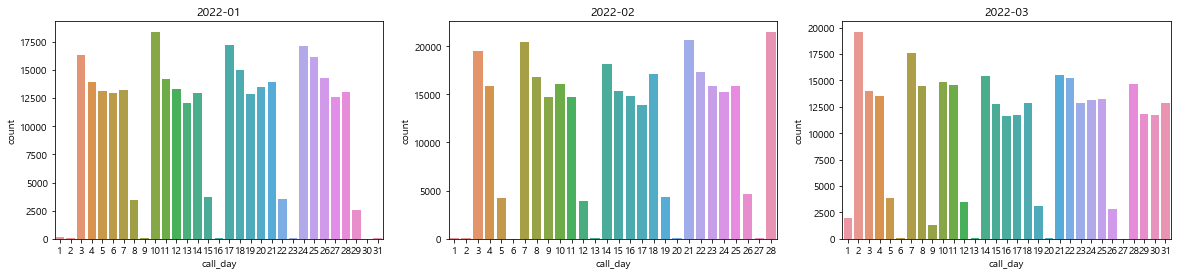

In [4]:
## '20년 월별 x 일자별 통화량 관찰하기 
call_cnt_01 = df_2022[df_2022['call_month'] == 1]
call_cnt_02 = df_2022[df_2022['call_month'] == 2]
call_cnt_03 = df_2022[df_2022['call_month'] == 3]
call_cnt_04 = df_2022[df_2022['call_month'] == 4]
call_cnt_05 = df_2022[df_2022['call_month'] == 5]
call_cnt_06 = df_2022[df_2022['call_month'] == 6]
call_cnt_07 = df_2022[df_2022['call_month'] == 7]
call_cnt_08 = df_2022[df_2022['call_month'] == 8]
call_cnt_09 = df_2022[df_2022['call_month'] == 9]
call_cnt_10 = df_2022[df_2022['call_month'] == 10]
call_cnt_11 = df_2022[df_2022['call_month'] == 11]
call_cnt_12 = df_2022[df_2022['call_month'] == 12]

figure, (ax1,ax2,ax3) = plt.subplots(ncols=3)
figure.set_size_inches(20,4)
sns.countplot(data=call_cnt_01, x='call_day', ax=ax1)
sns.countplot(data=call_cnt_02, x='call_day', ax=ax2)
sns.countplot(data=call_cnt_03, x='call_day', ax=ax3)
ax1.set(title = '2022-01')
ax2.set(title = '2022-02')
ax3.set(title = '2022-03')

[Text(0.5, 1.0, '2022-06')]

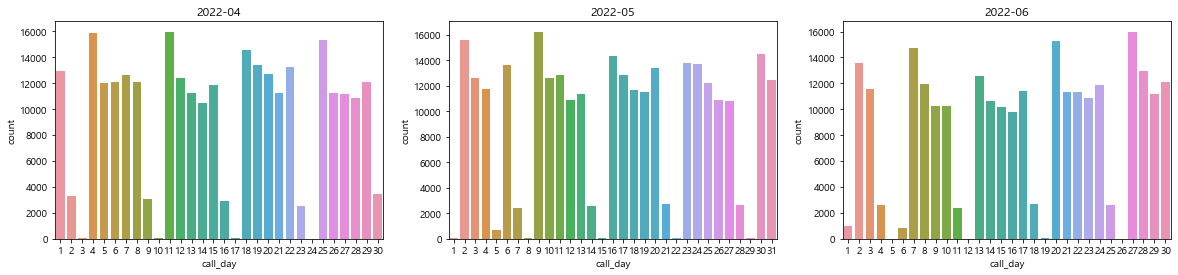

In [5]:
figure, (ax1,ax2,ax3) = plt.subplots(ncols=3)
figure.set_size_inches(20,4)
sns.countplot(data=call_cnt_04, x='call_day', ax=ax1)
sns.countplot(data=call_cnt_05, x='call_day', ax=ax2)
sns.countplot(data=call_cnt_06, x='call_day', ax=ax3)
ax1.set(title = '2022-04')
ax2.set(title = '2022-05')
ax3.set(title = '2022-06')

- 매주 월요일 또는 휴일 후 첫번째 영업일에 뚜렷한 통화량 증가, 반면 납부일자(5/10/20/25일)와 통화량은 관계성을 나타내지 않음 
--- 

#### 02. 연간 몇천건 이상 반복 인입되는 콜들의 출처별 비중은? 
- 카드사의 자동이체 등록/해지/변경 관련 : 신규카드 등록시 기존카드 자동해지 등의 프로세스 개선을 통해 인입콜 감소 가능? 
- 수납센터(추심사)의 미납안내 콜 : 수납센터에 이지원 권한부여 등의 방법을 통해 인입콜 감소 가능?
---

In [6]:
## 2-1. 카드사 -> 상담센터 인입콜의 빈도와 비중 파악 
## 먼저 웹검색을 통해 주요 카드사 고객센터 전화번호 조사 필요 
## (삼성:15888700, 롯데:15888100, 우리:15889955, KB:15881688 & 15881788, 신한:15447000, 현대:15776000, BC:15884000, 하나:18001111)

df_2022_from_cards = df_2022[df_2022['TEL'].str.contains('15888700|15888100|15889955|15881688|15881788|15447000|15776000|15884000|18001111', na=False)]
df_2022_from_cards.shape

(19836, 64)

In [7]:
KB = df_2022[df_2022['TEL'].str.contains('15881688', na=False)]
Shinhan = df_2022[df_2022['TEL'].str.contains('15447000', na=False)]
Woorie = df_2022[df_2022['TEL'].str.contains('15889955', na=False)]

print('- KB카드 콜수 =', KB['TEL'].value_counts())
print('- 신한카드 콜수 =', Shinhan['TEL'].value_counts())
print('- 우리카드 콜수 =', Woorie['TEL'].value_counts())

- KB카드 콜수 = 15881688    10128
Name: TEL, dtype: int64
- 신한카드 콜수 = 0215447000    8605
15447000        58
Name: TEL, dtype: int64
- 우리카드 콜수 = 15889955    1001
Name: TEL, dtype: int64


요금문의      14564
고객정보문의     2330
기타문의       1918
전입문의        302
전출문의         89
AS문의         27
검침문의         14
신규공급문의        7
안전점검문의        5
화재            3
경보기문의         1
Name: DUTY_TYPE, dtype: int64


[Text(0.5, 1.0, 'Woorie')]

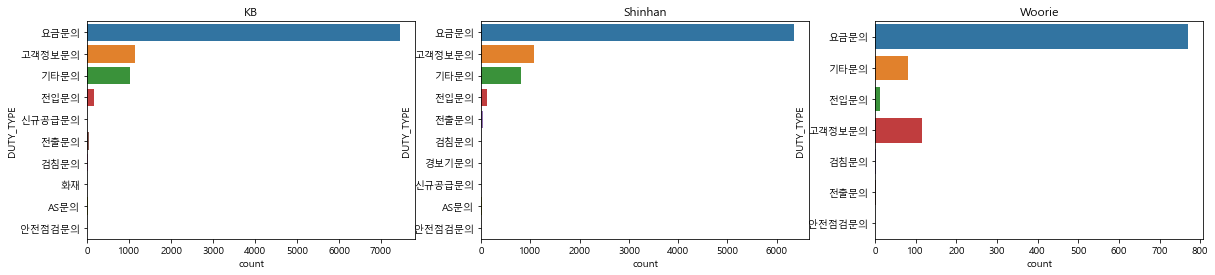

In [8]:
## Top 3 카드사별 상담유형 
card_top_3 = df_2022[df_2022['TEL'].str.contains('15881688|15447000|15889955', na=False)]
print(card_top_3['DUTY_TYPE'].value_counts())

figure, (ax1,ax2,ax3) = plt.subplots(ncols=3)
figure.set_size_inches(20,4)
sns.countplot(data=KB, y='DUTY_TYPE', ax=ax1)
sns.countplot(data=Shinhan, y='DUTY_TYPE', ax=ax2)
sns.countplot(data=Woorie, y='DUTY_TYPE', ax=ax3)
ax1.set(title = 'KB')
ax2.set(title = 'Shinhan')
ax3.set(title = 'Woorie')

In [9]:
## cf. 콜 유형 분류는 대부분 요금문의와 고객정보 문의이다. 그러나 실제 상담메모를 살펴보면 ... 
KB['COUNSEL_MEMO'][:20]

465                                              롯데카드해지
819                                            카드자동이체해지
909                                           자동이체해지만요청
1245                                   카드자동이체변경으로  해지요청
2005                                          자동이체 해지요청
2101                                             카드해지요청
2178                                    카드해지-카드사로 등록한다함
2185                                          세대무관 간단문의
2193             카드자동이체 해지및 LMS고지서요청  /3월요금 별도 납부하셔야함안내
2203                                               None
2232                                       카드 자동이체 해지만.
2441                                               자동해지
3192                                      카드해제만..문자발송안내
3489                               자이 해지 및 지로 고지서 변경 요청
4284    국민카드사 연락옴 >> 기존 카드해지 문의 >  본인 연락주셔서 해지요청만 가능안내.
4405                                             카드해지요청
4432                                             카드해지요청
4938                         카드사 고객번호 확인문의 -고객이 

In [10]:
Shinhan['COUNSEL_MEMO'][:20]

2                            자동이체만 해지
4                             자동이체 해지
168        카드자동이체 해제 문의 본인께서 연락주시라 안내
592                          고지금액확인함.
1031            이정숙01052313352 자동이체해지
2569                             None
3264                         납부자번호 확인
3277                             카드해지
3307     신한카드사전화,카드자동이체등록취소요청,고객취소요청함
4009             3-2일 신청한 국민카드 해지만 원함
4788             자동이체해지만/3월요금별도납부로안내함
5121                          자동이체 해지
5241                   자동이체 문자고지 해지요청
5534                             None
5871           자동이체 해지 요청 (카드사통한 요청 )
6712       김영남 - 자동이체접수/삼성카드로 접수되어 있슴
6858                      신한카드 3월적용안내
8351                             None
8695                        고객요청 /이소영
10021                              해지
Name: COUNSEL_MEMO, dtype: object

-일반콜의 평균 통화시간(초) = 129.25
-카드사콜의 평균 통화시간(초) = 88.63


[Text(0.5, 1.0, '카드사콜의 통화시간 분포(초)')]

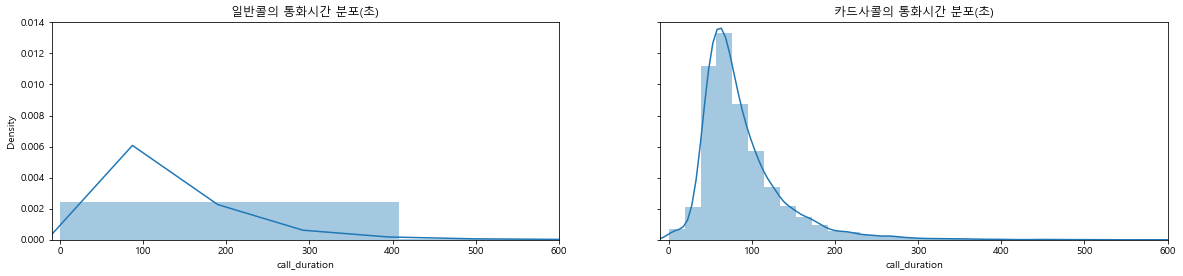

In [11]:
## 일반 콜과 카드사 콜의 질적 차이 (상담소요시간 비교)
a = np.mean(df_2022['call_duration'])
b = np.mean(df_2022_from_cards['call_duration'])

print('-일반콜의 평균 통화시간(초) =', round(a,2)) 
print('-카드사콜의 평균 통화시간(초) =', round(b,2))

figure, (ax1,ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
figure.set_size_inches(20,4)
sns.distplot(df_2022['call_duration'], ax=ax1)
sns.distplot(df_2022_from_cards['call_duration'], ax=ax2)
plt.xlim(-10, 600)
plt.ylim(0,0.014)
ax1.set(title = '일반콜의 통화시간 분포(초)')
ax2.set(title = '카드사콜의 통화시간 분포(초)')

--- 
- 메이저 8개 카드사 고객센터로부터의 인입콜은 '22년 기준 19,836건 (전체 약 3백만콜 중 0.6% 수준) 
- 카드사별로는 사별 점유율과 유사하게 KB > 신한 > 우리카드 순이며, 상담내역은 동일하게 카드 자동이체 등록/해지 관련 내용임
- 업무유형 분류체계에 자동이체 해지 관련 항목이 없음('요금문의'로 키인 하고 있음) --> 수정 필요성 검토 
- 통화시간 측면에서 카드사 콜은 일반콜대비 평균 40초 정도 짧고, 통화시간 분포도 평균 중심으로 몰려있음 --> 카드사콜은 상대적으로 대응이 짧고 간단한 내용인 것으로 추정됨 
- ###################################################################################################################################################################
- <span style="color:#ffd33d"> *약 2만콜 감축의 금전적 효과는 어느 수준일까? : (1) 건당 1천원 x 2만콜 = 약 2천만원/연  or  (2) 상담원 수 200명 x 0.6% = 1.2명(인당 인건비 36백만원) = 약 4천만원/연* </span>
--- 

In [12]:
## 2-2. 당사 수납센터(추심) -> 상담센터 인입콜의 빈도와 비중 파악 
## 수납센터 전화번호 ~ ( 미래: 031801997xx, SM: 023668xxxx, PnU: 026329xxxx )
df_2022_from_sn = df_2022[df_2022['TEL'].str.contains('031801997|023668|026329', na=False)]
df_2022_from_sn.shape

(29148, 64)

In [13]:
## 3개 수납센터별 인입콜수 
Mirae = df_2022[df_2022['TEL'].str.contains('031801997', na=False)]
SM = df_2022[df_2022['TEL'].str.contains('023668', na=False)]
PnU = df_2022[df_2022['TEL'].str.contains('026329', na=False)]

a = Mirae['TEL'].value_counts()
a1 = pd.DataFrame(a)
b = SM['TEL'].value_counts()
b1 = pd.DataFrame(b)
c = PnU['TEL'].value_counts()
c1 = pd.DataFrame(c)

print('- Mirae 콜수 =', a1.sum())
print('- SM 콜수 =', b1.sum())
print('- PnU 콜수 =', c1.sum())

- Mirae 콜수 = TEL    19751
dtype: int64
- SM 콜수 = TEL    1989
dtype: int64
- PnU 콜수 = TEL    7408
dtype: int64


요금문의        18005
고객정보문의       3940
기타문의         2376
체납문의         2253
전출문의          432
AS문의          396
전입문의          245
검침문의          202
차단/재공급불만       54
계량기문의          51
신규공급문의         24
안전점검문의         22
경보기문의           7
화재              3
고객정보관련불만        2
방문독촉및불만         1
체납수납센터불만        1
누출(가스냄새)        1
요금불만            1
Name: DUTY_TYPE, dtype: int64


[Text(0.5, 1.0, 'PnU')]

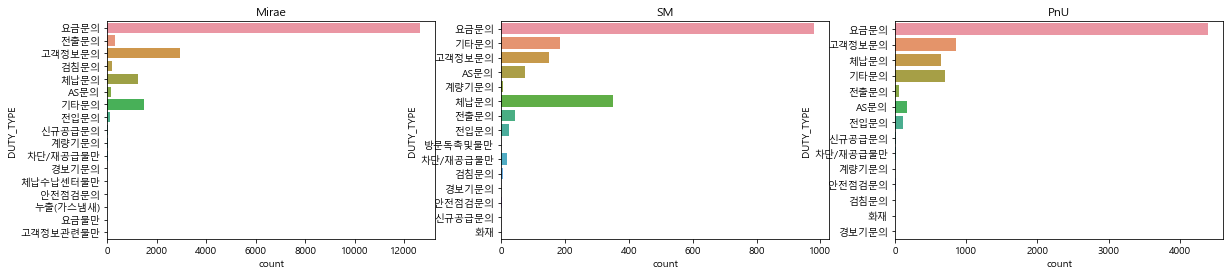

In [14]:
## 수납센터별 상담유형 
sn_3 = df_2022[df_2022['TEL'].str.contains('031801997|023668|026329', na=False)]
print(sn_3['DUTY_TYPE'].value_counts())

figure, (ax1,ax2,ax3) = plt.subplots(ncols=3)
figure.set_size_inches(20,4)
sns.countplot(data=Mirae, y='DUTY_TYPE', ax=ax1)
sns.countplot(data=SM, y='DUTY_TYPE', ax=ax2)
sns.countplot(data=PnU, y='DUTY_TYPE', ax=ax3)
ax1.set(title = 'Mirae')
ax2.set(title = 'SM')
ax3.set(title = 'PnU')

In [15]:
## cf. 콜 유형 분류는 요금문의가 대부분. 그러나 실제 상담메모를 살펴보면 ... 
Mirae['COUNSEL_MEMO'][:20]

1                                       수납센터: 번호변경&요금문자요청
7                   늦게방문요청. 현장정산.//전기렌지사용중 /진숙(전기사용한지3년됨)
487                            수납센타/중지철회시 납부확약서 필요/고객문자발송
659                                          신한 요금문자 수납센타
755     수납센터  폰삭제   &  사무실번호 등록요청   2021.11~2022.2월내역 ...
1084                                          문자고지등록/미납문자
1097                                    수납센터/ 번호변경 후 금액문자
1516                                                 None
1535                                                 카드등록
1592                     수납센터  폰 변경요청및   12~2월요금 가상번호  요청
1805                                            수납센터-요금문자
1927                          연락처 변겨후  20만원 금액,계좌문자/ 수납센타
2108              수납센터 ; 집주인 명의로 되어있고 거주자 따로 있음 \n고지서로 변경
2294                                                 None
2325                              가스는계속사용한다함 /검침확인안내// 주인
2463                                         자동이체 카톡고지접수함
2596                                  수납센타 요청/카드결제문의+명의등록
2600          

In [16]:
SM['COUNSEL_MEMO'][:20]

3035                                        None
3632                                        None
3940                            수납센터전화,무단사용재중지요청
4359                                수납센터)인입번호 안내
5782                              수납센터 등록번호 삭제요청
9944            2/10 통장에  금액 입금할꺼라고 미납문자 보내지 말라함
10002    재공급/수납센터 /일부수납으로 재공급/25일4시까지 나머지 납부하기로~
12491                        수납센터 - 미납요금 가상번호 발급
12773             수납센타  무단사용 재중지 요청  2/4일  커플링제거
14937                                       None
17797                      0020 : 잠금장치(키퍼체결) /송이
18616                               수납센터 페이번호 안내
19730                      1월ars가상번호 발급후 아내-수납센터
19977                                       수납센터
19992                              무단사용-재중지 수납센터
22217                                     수납센터전화
22530                          고지서 재발송 요청 / 수납센터
25047                                수납센터 재공급 요청
26339                        수납센터 1/4일 인입번호 확인요청
27606                            메일주소틀려서 재발송 9세대
Name: COUNSEL_MEMO, 

In [17]:
PnU['COUNSEL_MEMO'][:20]

150                     수납센터-인증x/010-8899-6663 인입 전화번호 받음
204                                      수납센터 / 2개월분 요금문자
443     수납센터 414,260원만 페이수납01021640894 요청 전산오류로 잠시후 문자...
1231                                            수납센터 문자발송
1424          수납센터 =>\n연락처(다른사람 사용번호로 삭제요청) 010 8912 3239
1531               수납센터 월별금액과 계좌 010-3403-8884 주인번호로 문자요청
1932                                   12.1월)-카드요청...수납센터
2277                                                 None
2330                              수납센터 재공급 요청, 핸드폰 번호 변경 
3340                                수납센터 전번삭제 요청 거주자 전번아님
4074                                   수납센터 / 두달요금 가상번호발급
4258                                               통합고지안내
4331                                         수납센터)인입번호 안내
4362                                        수납센터 -> 간단 안내
4635                                                 None
4861                                                 None
5248    수납센터 ) 요금 납부하실거라고 계좌생성해달라고하셨는데 미계약세대라서 고객님이랑통화...
6474          

-일반콜의 평균 통화시간(초) = 129.25
-수납센터콜의 평균 통화시간(초) = 69.13


[Text(0.5, 1.0, '수납센터콜의 통화시간 분포(초)')]

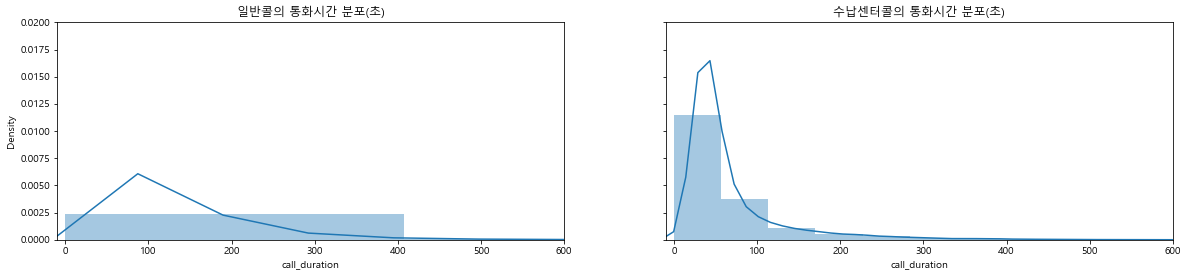

In [18]:
## 일반 콜과 수납센터 콜의 질적 차이 (상담소요시간 비교)
a = np.mean(df_2022['call_duration'])
b = np.mean(df_2022_from_sn['call_duration'])

print('-일반콜의 평균 통화시간(초) =', round(a,2)) 
print('-수납센터콜의 평균 통화시간(초) =', round(b,2))

figure, (ax1,ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
figure.set_size_inches(20,4)
sns.distplot(df_2022['call_duration'], ax=ax1)
sns.distplot(df_2022_from_sn['call_duration'], ax=ax2)
plt.xlim(-10, 600)
plt.ylim(0,0.02)
ax1.set(title = '일반콜의 통화시간 분포(초)')
ax2.set(title = '수납센터콜의 통화시간 분포(초)')

--- 
- 3개 수납센터로부터의 인입콜은 '22년 기준 29,148건 (전체 약 3백만콜 중 약 1% 수준), 특히 "미래"로부터의 콜 인입이 약 67%를 차지함 
- 업무유형은 앞서 카드사와 마찬가지로 대부분 '요금문의'로 분류되고 있으나, 상담메모 확인 결과 정보변경/납부방법 안내/재공급 요청 등 다양한 내용들임 
- 통화시간 또한 일반콜 대비 평균 60초 정도 짧은, 즉 상대적으로 대응이 짧고 간단한 통화로 해결되고 있는 것으로 판단됨 
#############################################################################################################################
- <span style="color:#ffd33d"> 카드사 + 수납센터 인입콜 합산 연간 약 5만콜(비중 약 1.7%) --> 상담원 200명 x 1.7% = 3.4명 감축 가능? </span>
--- 

방문독촉및불만     11817
요금불만         1026
차단/재공급불만      375
고객정보관련불만      259
안전점검불만        155
검침불만          131
직원서비스불만        91
기타불만           65
계량기업무불만        55
회사불만           18
체납수납센터불만        9
신규공급관련불만        4
Name: DUTY_TYPE, dtype: int64


<AxesSubplot:xlabel='count', ylabel='DUTY_TYPE'>

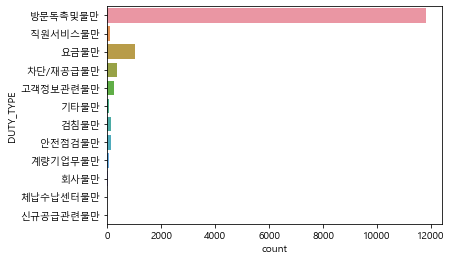

In [24]:
complain = df_2022[df_2022['DUTY_TYPE_CLAS'] == '불만']
print(complain['DUTY_TYPE'].value_counts())
sns.countplot(data=complain, y='DUTY_TYPE')

In [25]:
complain['COUNSEL_MEMO'][:30]

208                            기사연락처문의/
355              당일 오전 방문예정 / 기사 연락예정안내
2078                   방문 시간 관련 민원 홈페이지
2398                            독촉-기사전달
2830                                독촉옴
2948                             접수시간확인
3237                               None
3317                               접수확인
3558                             당일방문예정
4195                             8일로 안내
4726                                 독촉
4860                            현장직원 문발
5021                       방문시간문의/ 기사전달
5137                               None
5446                               None
5448       방문시간전화요청/010-8947-1253 /기사전달
6066                               None
6466       인정고지 과다로 불만. 고객에게 전화 부탁드립니다.
6643                            오후 방문안내
6724                               예약확인
6996                        부동산 정산완료 확인
7204                             가스사용방법
7942     방문시간문의/ 기사 방문전 연락드림 정산되면 문자발송됨
8097                3/22일 완납확인/오전빠른재개요청
8104                               None
